In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import os
import pickle
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

import PIL


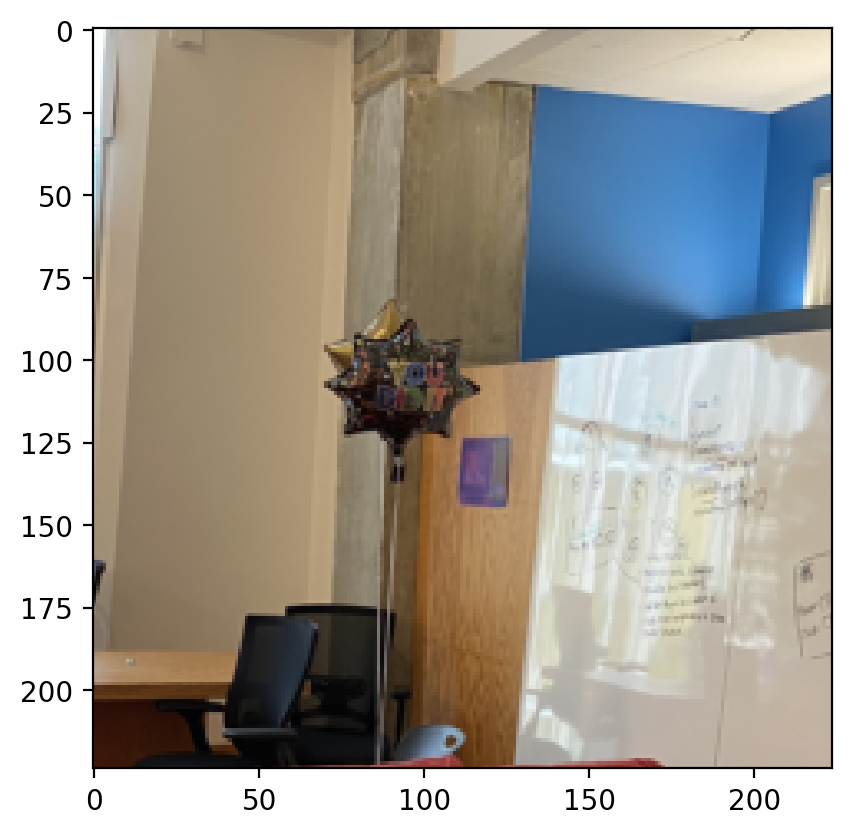

In [2]:
TRAIN_PATH = 'split_dataset/train'


def get_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])


def get_augmented_data_loader(augmented_transform):
    train_set = datasets.ImageFolder(TRAIN_PATH, transform=augmented_transform)
    val_set = datasets.ImageFolder(TRAIN_PATH, transform=get_transform())
    return train_set, val_set


random_crop = transforms.Compose([
    transforms.RandomCrop(1500),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_set, val_set = get_augmented_data_loader(random_crop)
plt.imshow(train_set[4][0].permute(1, 2, 0))

In [17]:
def load_model(name):
    model_path = os.path.join('results', f'{name}.model')
    hist_path = os.path.join('results', f'{name}.hist')
    model = torch.load(model_path)
    with open(hist_path, 'rb') as f:
        hist = pickle.load(f)
    return model, hist


def plot_hist(hists):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.text(0.5, 0.04, 'Epoch', ha='center')
    ax1.set_title('Training Loss')
    ax1.set_ylabel('Loss')
    ax2.set_title('Validation Top1 Accuracy')
    ax2.set_ylabel('Accuracy %')
    xs = range(1, len(hists[0][0][0]) + 1)
    ax1.set_xticks(xs)
    ax2.set_xticks(xs)
    for (hist, name) in hists:
        ax1.plot(xs, hist[0], label=name)
        ax2.plot(xs, hist[1], label=name)
        print(f'{name} final accuracy: {hist[1][-1]}')
    ax1.legend()
    ax2.legend()

Baseline final accuracy: 80.0
Last Layer final accuracy: 90.0
All Layers final accuracy: 100.0
Kaiming Uniform final accuracy: 60.0
Random Rotation final accuracy: 80.0
Random Crop final accuracy: 80.0
Random Blur final accuracy: 90.0


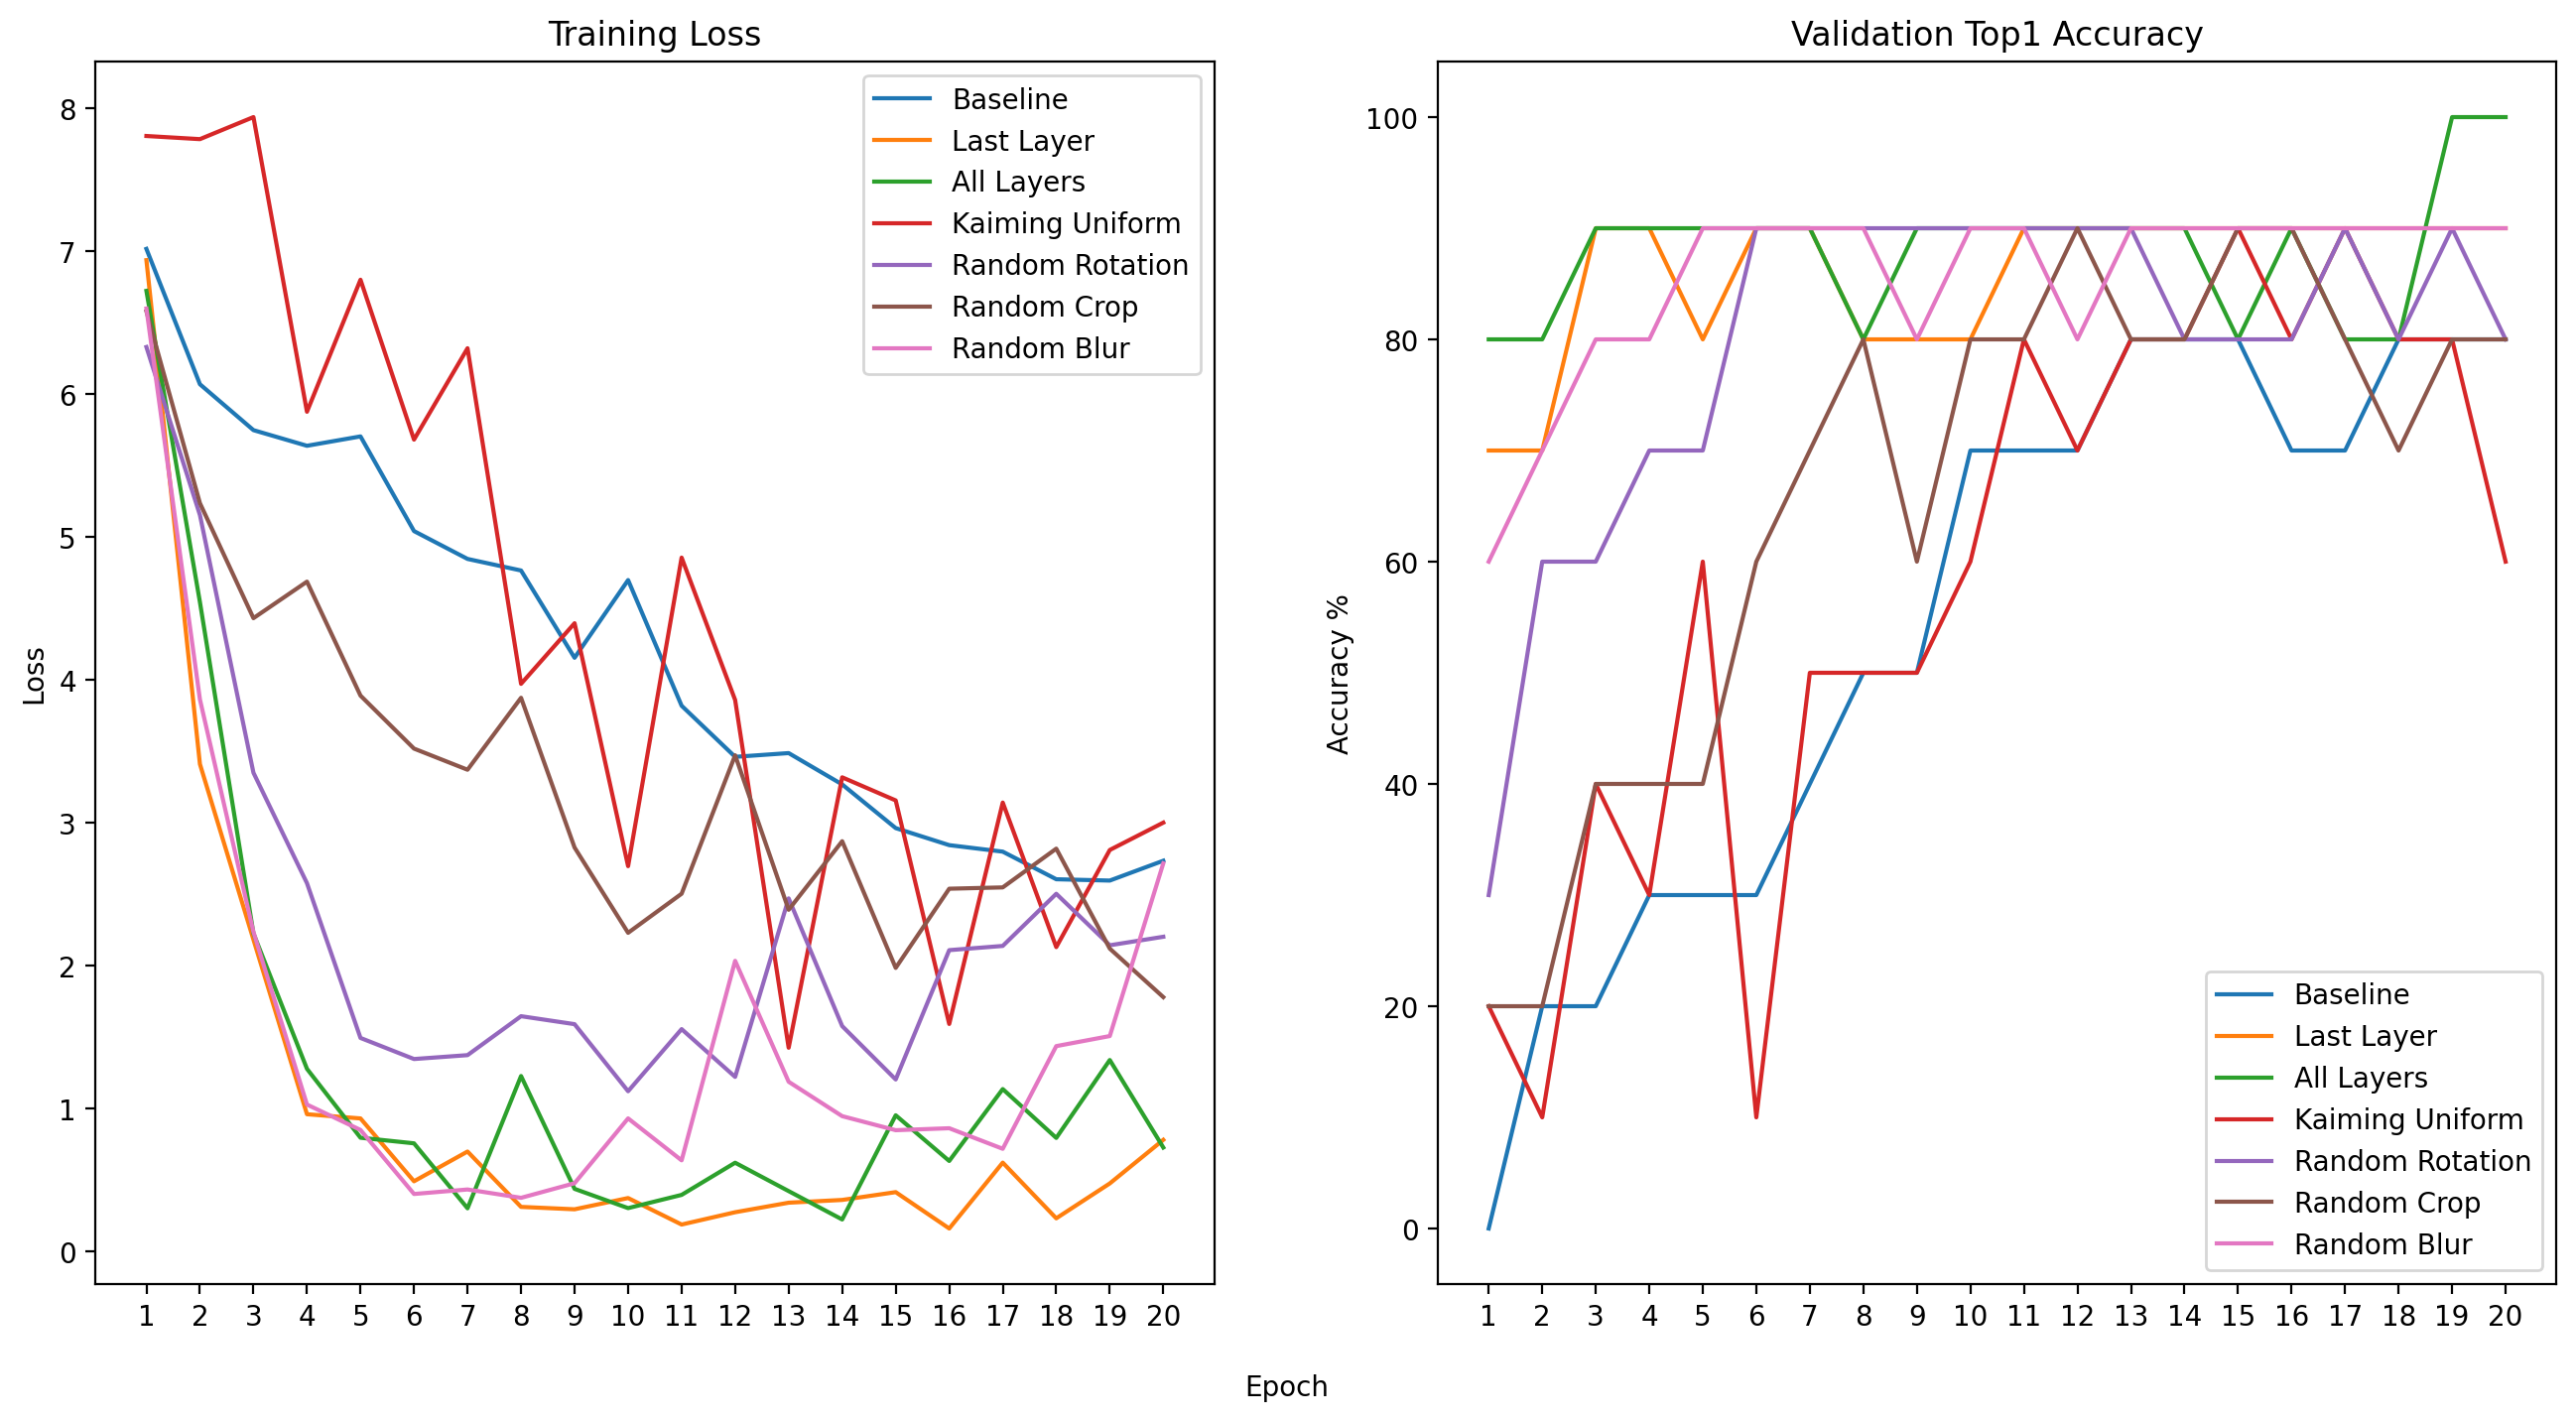

In [18]:
baseline_model, baseline_hist = load_model('baseline')
all_model, all_hist = load_model('resnet_all')
last_model, last_hist = load_model('resnet_last_layer')
random_blur_model, random_blur_hist = load_model('random_blur')
random_crop_model, random_crop_hist = load_model('random_crop')
random_rotation_model, random_rotation_hist = load_model('random_rotation')
kaiming_model, kaiming_hist = load_model('kaiming_uniform')

plot_hist([
    (baseline_hist, 'Baseline'),
    (last_hist, 'Last Layer'),
    (all_hist, 'All Layers'),
    (kaiming_hist, 'Kaiming Uniform'),
    (random_rotation_hist, 'Random Rotation'),
    (random_crop_hist, 'Random Crop'),
    (random_blur_hist, 'Random Blur'),
])

In [26]:

def visualize_resnet_features(model, image):
    image = image.unsqueeze(0)
    outputs = []
    names = []
    i = 1
    for layer in model.resnet_layers[:4]:
        image = layer(image)
        outputs.append(image)
        names.append(f'layer {i}')
        i += 1
    for seq in model.resnet_layers[4:8]:
        for layer in seq:
            image = layer(image)
            outputs.append(image)
            names.append(f'layer {i}')
            i += 1
    # # print feature_maps
    # for feature_map in outputs:
    #     print(feature_map.shape)

    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    # for fm in processed:
    #     print(fm.shape)

    # fig = plt.figure(figsize=(30, 50))
    # for i in range(len(processed)):
    #     a = fig.add_subplot(5, 4, i+1)
    #     imgplot = plt.imshow(processed[i])
    #     a.axis("off")
    #     a.set_title(names[i].split('(')[0], fontsize=30)
    fig = plt.figure(figsize=(8, 8))
    for i in range(4):
        a = fig.add_subplot(2, 2, i+1)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(names[i].split('(')[0], fontsize=30)
    # plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

torch.float32

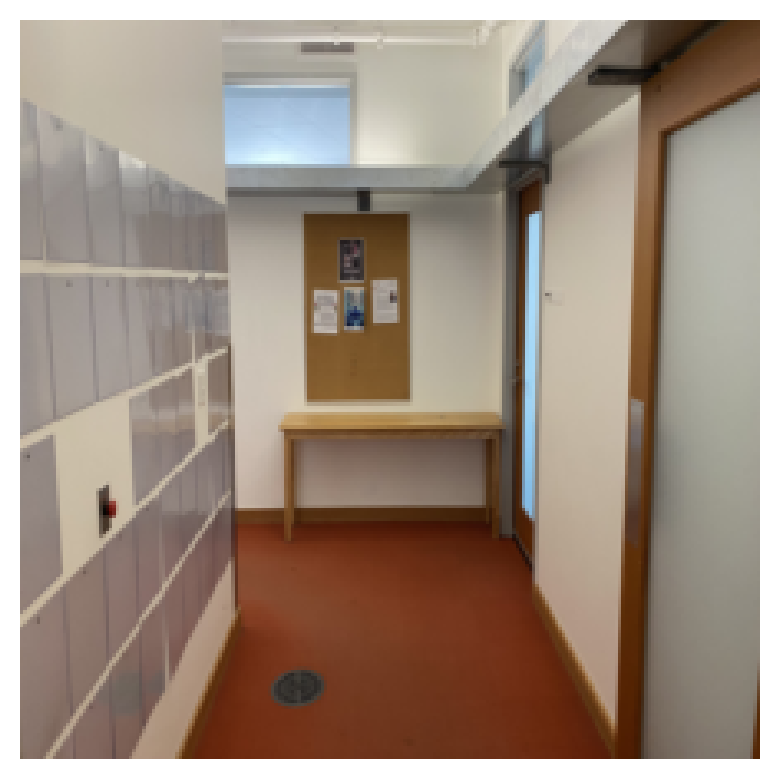

In [29]:
image = val_set[0][0]
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
image.dtype

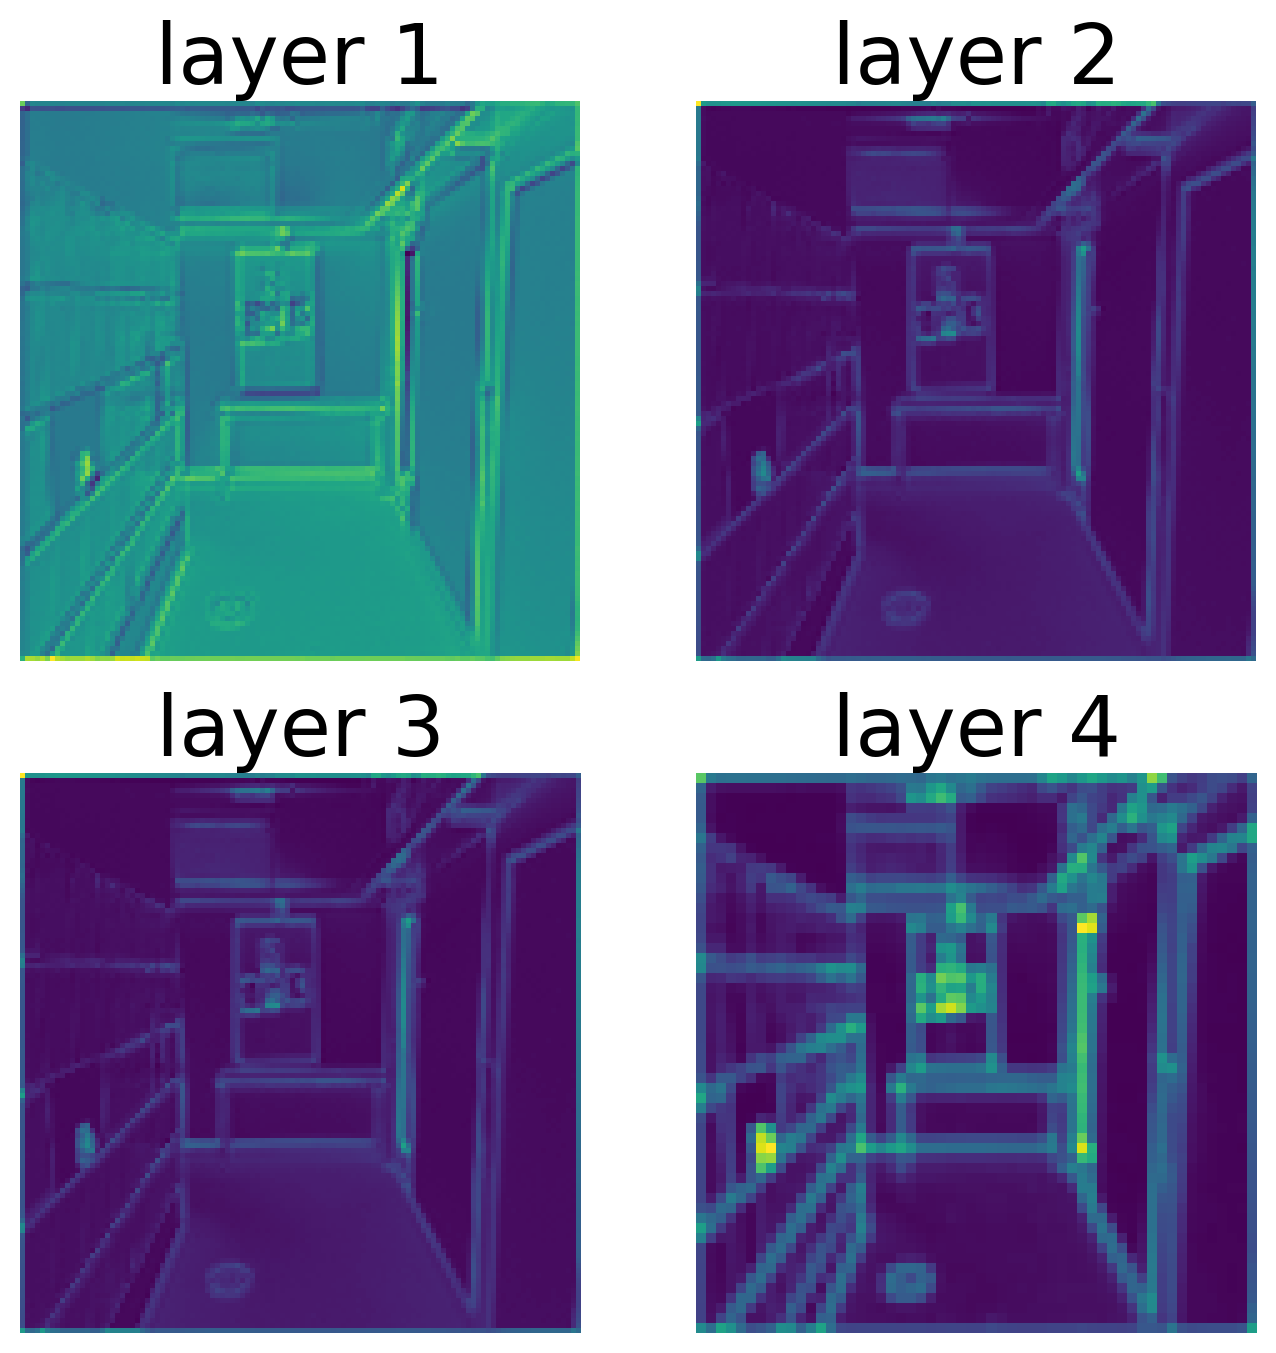

In [28]:
visualize_resnet_features(all_model, image)

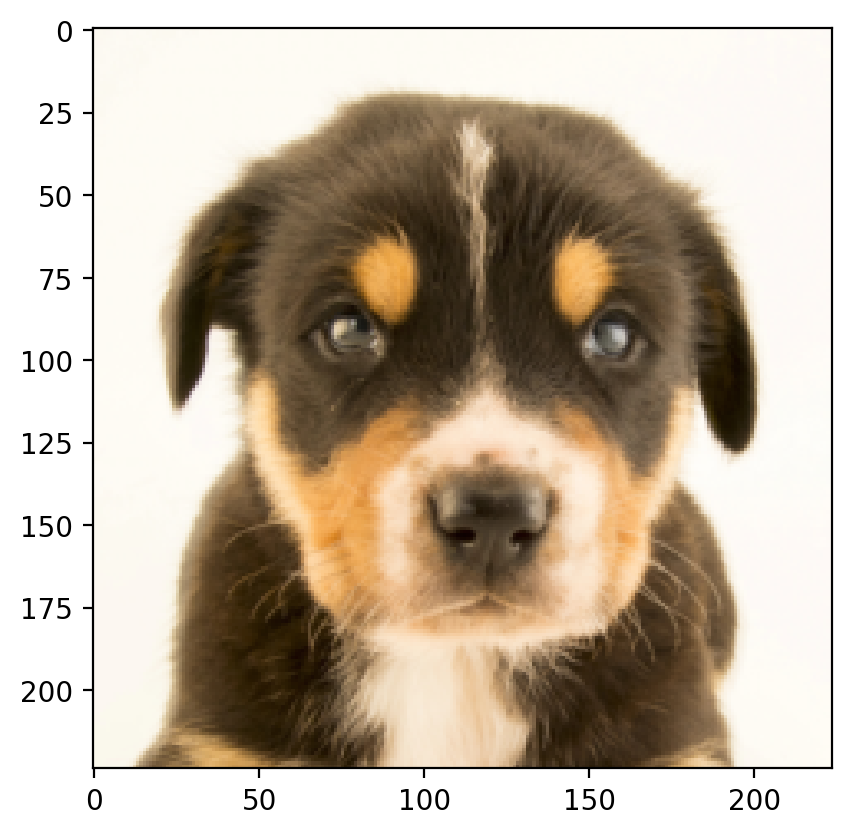

In [18]:
image = get_transform()(PIL.Image.open("dog.jpeg"))
plt.imshow(image.permute(1, 2, 0))

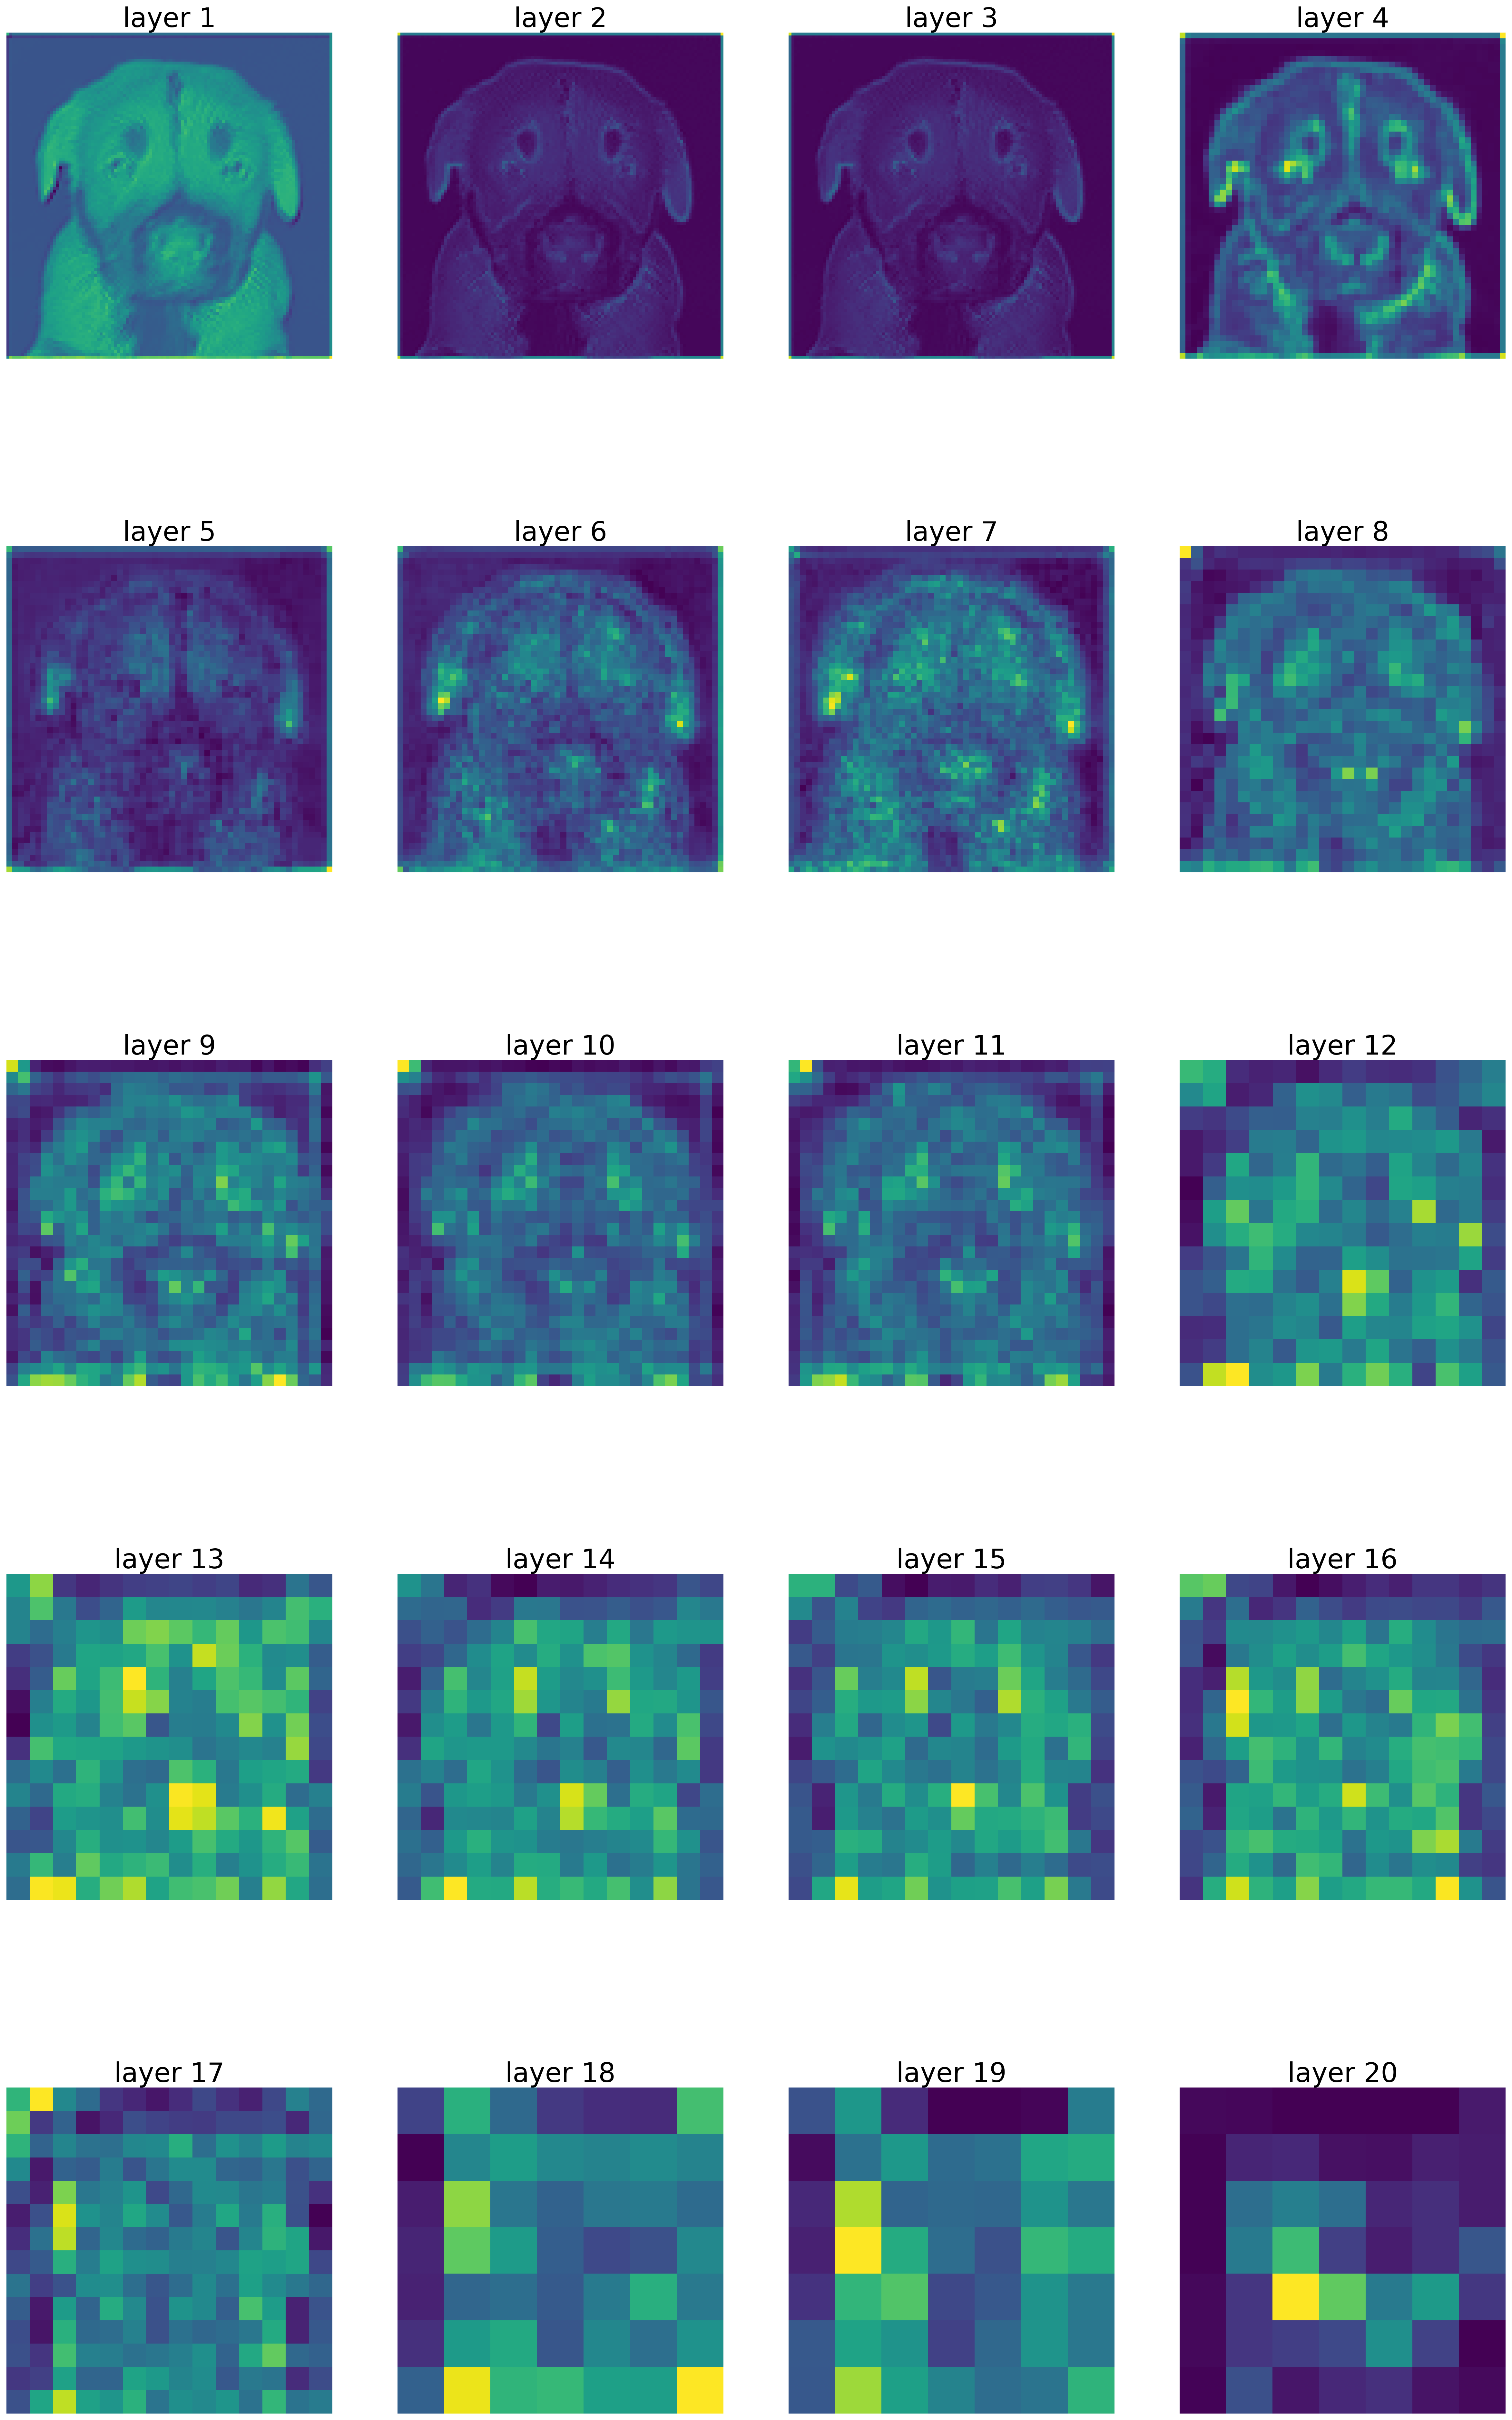

In [19]:
class Original():
    def __init__(self):
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        layers = list(resnet.children())[:-1]
        self.resnet_layers = nn.Sequential(*layers)
        
visualize_resnet_features(Original(), image)

In [5]:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
# layers = list(resnet.children())[:-1]
# print(layers[0].weight)
# torch.nn.init.kaiming_uniform_(layers[0].weight)
# print(layers[0].weight)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 